# Adjusting the model

In the previous notebook we tweaked hyperparameters for SVM in order to boost its accuracy. 

Here we will explore two other models, Random Forests and Logistic Regression in a bid to achieve more accuracy in our disease prediction question.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pprint import pprint

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,precision_score,recall_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
def evaluate_model(model, model_name, test_features, test_labels):
    """ Evaluate a model using test data. Print the precision. """
    
    predictions = model.predict(test_features)
    accuracy = round(100*accuracy_score(test_labels, predictions),2)
    print("The accuracy of the {} model is {}%".format(model_name, accuracy))

# Prepare data for the ML model

In [3]:
# Import the data and build the pandas dataframe
# Split into class/features
features = load_breast_cancer()
labels = features['target']
features = pd.DataFrame(data=features['data'], columns=features['feature_names'])

# Split into train/test
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2,
                                                                           random_state=1)

## Feature Scaling, Min-Max Scaler

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
train_features_scaled = pd.DataFrame(scaler.fit_transform(train_features))
train_features_scaled.columns = train_features.columns
train_features_scaled.index = train_features.index.values

test_features_scaled = pd.DataFrame(scaler.fit_transform(test_features))
test_features_scaled.columns = test_features.columns
test_features_scaled.index = test_features.index.values

# SVM

Lets quickly rebuild what was done in the previous notebook

In [5]:
# Train the model using the hyperparameters discovered in the last notebook
svm_model = SVC(C=8, gamma=1, kernel='linear', random_state=1)
svm_model.fit(train_features_scaled, train_labels)

# Test & Evaluate the model
evaluate_model(svm_model, 'SVM', test_features_scaled, test_labels)

The accuracy of the SVM model is 98.25%


# Random Forests

Random Forests do not require data normalizaton.

In [6]:
# Train the model
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(train_features, train_labels)

# Test & evaluate the model
evaluate_model(rf_model, 'RF', test_features, test_labels)

The accuracy of the RF model is 95.61%


## Hyperparameter tunning

**95.61%** is not bad for a starter. Lets do some hyperparameter tunning and see what we come up with. 

We shall work with the following hyperparameters ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) explaining them):
- n_estimators: number of trees in the forest
- max_features: number of features taken into consideration while building the tree
- max_depth: the maximum depth that the tree can take
- min_samples_split: the minimal number of samples required if a node is to be split further
- min_samples_leaf: the minimal number of samples before a node is declared to be a leaf
- bootstrap: random forests consist of two randomized processes. If this is False than the whole dataset is used to build each tree

Let's first see the current state of hyperparameters.

In [7]:
pprint(rf_model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [8]:
n_estimators = [x for x in range(200, 2200, 200)]
max_features = ['auto', 'log2']
max_depth = [x for x in range(10, 110, 10)]
max_depth.append(None)
min_samples_split = [2,4,9]
min_samples_leaf = [1,2,3,4]
bootstrap = [True, False]

# Create random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'log2'],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [2, 4, 9],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


So the RandomizedSearchCV will pick different settings out of a total of 5808 combinations. We will try out 200 out of these.

In [18]:
rf = RandomForestClassifier()

# scoring: method of evaluating the predictions on the test set
rf_model_rand = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=200, 
                                  scoring='neg_mean_absolute_error', cv=3, verbose=3, random_state=1,
                                  n_jobs=-1)

rf_model_rand.fit(train_features, train_labels);

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 13.9min finished


In [20]:
rf_model_rand.best_params_

{'n_estimators': 1200,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 100,
 'bootstrap': False}

Test and evaluate the model

In [42]:
evaluate_model(rf_model_rand.best_estimator_, "RF with hyperparameter improvement 1", test_features, test_labels)

The accuracy of the RF with hyperparameter improvement 1 model is 95.61%


Refine search with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV)

In [44]:
# Try out 720 different parameter sets
grid_param = {
    'n_estimators':[1000,1200,1400,1600],
    'min_samples_split':[2,3,4,5,6,8],
    'min_samples_leaf':[2,3,4,5,6,8],
    'max_features': ['log2'],
    'max_depth': [80, 100, 120, 140, 200]
}

rf = RandomForestClassifier()

rf_model_grid = GridSearchCV(estimator=rf, param_grid=grid_param, cv=5, n_jobs=3, verbose=3)
rf_model_grid.fit(train_features, train_labels);

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   31.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed:  6.6min
[Parallel(n_jobs=3)]: Done 506 tasks      | elapsed: 12.3min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 19.6min
[Parallel(n_jobs=3)]: Done 1146 tasks      | elapsed: 28.9min
[Parallel(n_jobs=3)]: Done 1562 tasks      | elapsed: 39.7min
[Parallel(n_jobs=3)]: Done 2042 tasks      | elapsed: 52.2min
[Parallel(n_jobs=3)]: Done 2586 tasks      | elapsed: 69.2min
[Parallel(n_jobs=3)]: Done 3194 tasks      | elapsed: 86.6min
[Parallel(n_jobs=3)]: Done 3600 out of 3600 | elapsed: 98.8min finished


In [45]:
rf_model_grid.best_params_

{'max_depth': 120,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 1200}

We can stop here and see the final performance of the RF model as compared to the SVM model.

In [47]:
evaluate_model(rf_model, 'RF no hyperparameters', test_features, test_labels)
evaluate_model(rf_model_grid.best_estimator_, "RF with hyperparameter tuning", test_features, test_labels)

The accuracy of the RF no hyperparameters model is 95.61%
The accuracy of the RF with hyperparameter tuning model is 94.74%


And we got diminishing returns...

Our efforts in hyperparameter tuning for RF were not successful

## Variable Importances

Moreover we can check variable importances and see if we can boost the RF model's performance in this way.

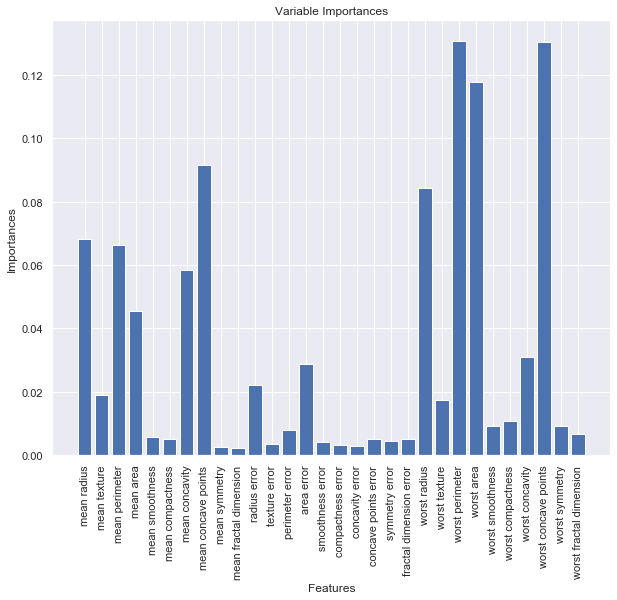

In [9]:
importances = list(rf_model.feature_importances_)

# plot
plt.figure(figsize=(10,8))
plt.bar(list(features.columns), importances)
plt.xticks(rotation='vertical')
plt.xlabel("Features"); plt.ylabel("Importances"); plt.title("Variable Importances"); plt.show()

### Build a model with the top 8 most important variables

Since we see that not all variables are equally important, lets pick the top 8 most important and build a model out of that.

In [10]:
n_features = 8

# Sort importances and pick the top 8
importances = [(name, imp) for imp, name in zip(importances,features.columns)]
importances.sort(key=lambda tup: tup[1], reverse=True)
top_feat = [importances[i][0] for i in range(n_features)]
top_feat

['worst perimeter',
 'worst concave points',
 'worst area',
 'mean concave points',
 'worst radius',
 'mean radius',
 'mean perimeter',
 'mean concavity']

In [11]:
important_features_train = train_features[top_feat]
important_features_test = test_features[top_feat]

# Train the new model
rf_impt_feat = RandomForestClassifier(random_state=1)
rf_impt_feat.fit(important_features_train, train_labels)

evaluate_model(rf_impt_feat, "RF only with important features", important_features_test, test_labels)

The accuracy of the RF only with important features model is 95.61%


The accuracy does not increase. Despite our efforts it seems that we cannot further boost this model. We now move to logistic regressions.

# [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

We saw a little bit in the Random Forest model that not all features are equally important. Some are much more important than others. Therefore we shall use Lasso Regression so that the algorithm discards potentially useless features. Lasso Regression can shrink the slope all the way to 0 thereby removing redundant features.

## Scaling
### Min-Max

In [28]:
# Train
lr1 = LogisticRegression(random_state=1, penalty='l1', solver='liblinear')
lr1.fit(train_features_scaled, train_labels)

# Test & Evaluate
evaluate_model(lr1, "Logistic Regression", test_features_scaled, test_labels)

The accuracy of the Logistic Regression model is 95.61%


### Standard Scaler

In [12]:
scaler2 = StandardScaler()

train_features_scaled2 = pd.DataFrame(scaler2.fit_transform(train_features))
train_features_scaled2.columns = train_features.columns
train_features_scaled2.index = train_features.index.values

test_features_scaled2 = pd.DataFrame(scaler2.fit_transform(test_features))
test_features_scaled2.columns = test_features.columns
test_features_scaled2.index = test_features.index.values

# Train model
lr2 = LogisticRegression(random_state=1, penalty='l1', solver='liblinear')
lr2.fit(train_features_scaled2, train_labels)

# Test & Evaluate
evaluate_model(lr2, "Logistic Regression", test_features_scaled2, test_labels)

The accuracy of the Logistic Regression model is 97.37%


So, Standard Scaler seems to perform much better for logistic regression, namely **97.37%** as opposed to the **95.61%** of the Min-Max Scaler.

## Evaluation of the Model using Cross Validation

In [13]:
lr_accuracy = cross_val_score(estimator=lr2, X=train_features_scaled2, y=train_labels, cv=10)
print("Accuracy of the Linear Regression model with a 10-fold CV:", round(100*np.mean(lr_accuracy), 2))

Accuracy of the Linear Regression model with a 10-fold CV: 96.94


We do not notice any improvement...

# Conclusions

In [14]:
evaluate_model(svm_model, 'SVM', test_features_scaled, test_labels)
evaluate_model(lr2, "Logistic Regression", test_features_scaled2, test_labels)
evaluate_model(rf_model, 'RF', test_features, test_labels)

The accuracy of the SVM model is 98.25%
The accuracy of the Logistic Regression model is 97.37%
The accuracy of the RF model is 95.61%


We saw 3 models applied on our dataset on a bid to increase the accuracy. The scoring is as follows:

1. SVM: **98.25%**
2. Logistic Regression: **97.37%**
3. Random Forests: **95.61%**

The referenced [paper](https://www.sciencedirect.com/science/article/pii/S1877050916302575) has these results:
1. SVM: **97.13%**
2. Naive Bayes: **95.99%**
3. k-NN: **95.27%**
4. Decision Trees: **95.13%**

As can be seen our SVM model performs better than the papers and this can be probably credited to the kernel choice resulting from the hyperparameter tuning, as we saw in the last notebook (we use a linear instead of a rbf kernel). 

Moreover, the Logistic Regression model also performs better than the paper's SVM.

Random Forests have a disappointing performance when compared to SVM.
